데이터를 만들어보자.
구글에서 장미 검색


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
torch.manual_seed(777)
IMAGE_SIZE = 128

device='cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
print(device)

cpu


In [3]:
test_dataset=ImageFolder(root='../data02/images/',
                         transform=transforms.Compose([
                           transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
                           transforms.ToTensor()
                         ])
                         )

test 데이터 로드

In [4]:
test_loader=DataLoader(test_dataset,
                       batch_size=10,
                       shuffle=False,
                       num_workers=1)


이미지와 레이블 추출
안에 테스트 폴더 하나 뿐이라서 다 0이 나와.

In [7]:
images, labels=next(iter(test_loader))
print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [8]:
images.size()

torch.Size([10, 3, 128, 128])

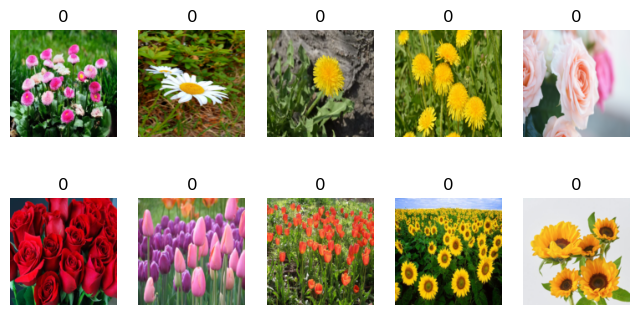

In [21]:
def plot(x, y):
  plt.figure(figsize=(8,4))
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(y[i].item()) #tensor니까 item
    plt.imshow(x[i].permute(1,2,0)) #텐서(chanel, row, col) 그림을 그릴때는 aray로 있어야해.:배열(row, col, channel)
    plt.axis('off')
  plt.show()

plot(images, labels)

In [11]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__() 

    self.layer1= nn.Sequential(
      nn.Conv2d(3, 8, 3, padding=1), 
      nn.ReLU(),
      # nn.Dropout(0.25), 딥러닝 선의 25% 날려. 오버피팅 방지
      # nn.BatchNorm2d() 정규화도 가능, 1D든 2D든
      nn.MaxPool2d(kernel_size=2, stride=2) # 64*64
    )

    self.layer2= nn.Sequential(
      nn.Conv2d(8, 16, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # 32*32
    )

    self.layer3= nn.Sequential(
      nn.Conv2d(16, 32, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) #16*16
    )

    self.layer4= nn.Sequential(
      nn.Conv2d(32, 64, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) #64*8*8
    )

    self.layer5= nn.Sequential(
      nn.Conv2d(64, 128, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # 128*4*4 만큼 특징이 있다.
    )    

    #완전 연결층

    self.fc1=nn.Linear(128*4*4, 128) #128은 내 맘대로, 은닉층의 수는 모델개발자가 선택
    self.fc2=nn.Linear(128, 64)
    self.fc3=nn.Linear(64,5)

  def forward(self, x): #파이썬의 함수는 항상 self가 들어온다
    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)
    x=self.layer5(x)

    #컨볼루션 층 끝!

#3차원 이미지
    x=x.view(-1, 128*4*4)
    x=self.fc1(x)
    x=self.fc2(x)
    x=self.fc3(x)
#소프트맥스에 넣어줘야하지만 crossentropy에 넣을 거라서 바로 리턴

    return x
      



In [12]:
model=CNN().to(device)
model.load_state_dict(torch.load('../data02/model.pt'))
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [13]:
pred=model(images.to(device)).argmax(dim=-1) #1이든 -1이든
print(pred)

tensor([4, 0, 1, 3, 4, 4, 4, 4, 3, 0])


0 데이지
1 민들레
2 장미
3 해바라기
4 튤립

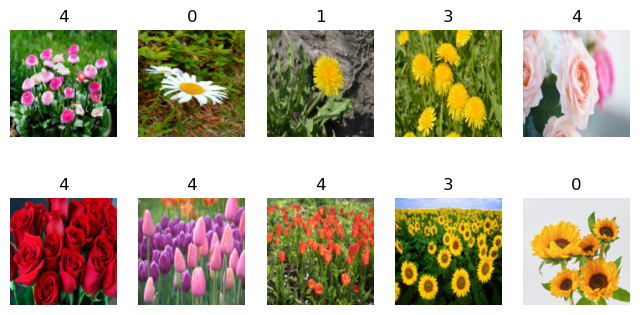

In [22]:
plot(images, pred)

kaggle 
https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images